In [ ]:
# System setup (install necessary packages only once)
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


In [ ]:
 # ✅ Step 2: Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/My Drive/dataa/train_test_data.zip'
extract_path = '/content/train_test_data'  # You can change this folder if you want

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done!")

# Step 3: List extracted files to verify
extracted_files = os.listdir(extract_path)
print("Extracted files:")
for file in extracted_files:
    print(file)

Extraction done!
Extracted files:
test
train
dataset_dict.json


In [ ]:
from datasets import load_from_disk

# Load the dataset
dataset = load_from_disk("/content/train_test_data")

# Split into training and evaluation sets
train_dataset = dataset['train']
eval_dataset = dataset['test']

# Optional: peek at a few examples
print("Train example:", train_dataset[0])
print("Eval example:", eval_dataset[0])


Train example: {'instruction': "If you are a doctor, please answer the medical questions based on the patient's description.", 'input': 'My grand daughter just came from her OB and they said that she definitely was pregnant, but now it is detaching from the uterus. She has slight cramping; nothing major, no bleeding. She was given a prescription for suppositories to induce the D&C affect. Should she take these without any other symptoms present at this time?', 'output': "Respected user, thanks for using Chat Doctor.come have evaluated your query thoroughly.* Cramps during pregnancy may be due to - non-specific cause - uterine expansion via growing fetus - placental separation - fetal movements related - other abdominal causes * Only pain is not the criteria for induction of D&C effect, there are many parameters gone doctor evaluate and then decide for the prescription.* I strongly recommend following strictly your doctor's advise only. Hope to clarify your query. Welcome for further as

In [ ]:
def formatting_func(example):
    return f"### The following is a doctor's opinion on a patient's query:\n### Patient query: {example['input']}\n### Doctor opinion: {example['output']}"

print(formatting_func(train_dataset[0]))


### The following is a doctor's opinion on a patient's query:
### Patient query: My grand daughter just came from her OB and they said that she definitely was pregnant, but now it is detaching from the uterus. She has slight cramping; nothing major, no bleeding. She was given a prescription for suppositories to induce the D&C affect. Should she take these without any other symptoms present at this time?
### Doctor opinion: Respected user, thanks for using Chat Doctor.come have evaluated your query thoroughly.* Cramps during pregnancy may be due to - non-specific cause - uterine expansion via growing fetus - placental separation - fetal movements related - other abdominal causes * Only pain is not the criteria for induction of D&C effect, there are many parameters gone doctor evaluate and then decide for the prescription.* I strongly recommend following strictly your doctor's advise only. Hope to clarify your query. Welcome for further assistance. Thanks for using Chat Doctor .com & giv

In [ ]:
base_model_id = "tiiuae/falcon-7b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [ ]:
max_length = 512

def generate_and_tokenize_prompt(example):
    tokenized = tokenizer(
        formatting_func(example),
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

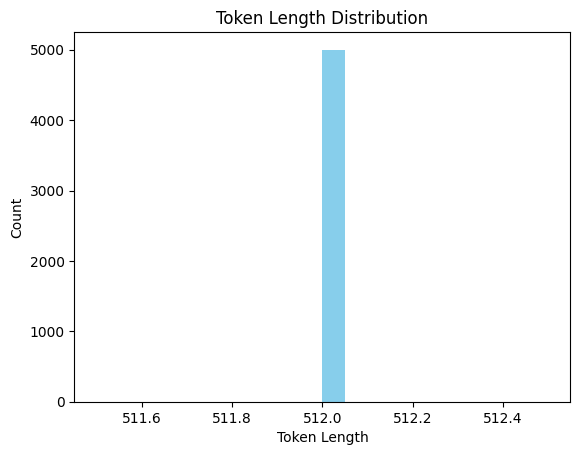

In [ ]:
def plot_data_lengths(train_data, val_data):
    lengths = [len(x['input_ids']) for x in train_data] + [len(x['input_ids']) for x in val_data]
    plt.hist(lengths, bins=20, color='skyblue')
    plt.xlabel('Token Length')
    plt.ylabel('Count')
    plt.title('Token Length Distribution')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)


In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],  # Falcon-specific
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="./falcon-patient-chatbot",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    eval_steps=10,
    save_steps=10,
    logging_steps=5,
    learning_rate=2e-4,
    max_steps=20,
    save_total_limit=1,
    report_to="none",
    logging_dir="./logs",
    optim="paged_adamw_8bit"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
10,2.657800,2.619276
20,2.558700,2.573808


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=20, training_loss=2.670251703262329, metrics={'train_runtime': 4997.7331, 'train_samples_per_second': 0.032, 'train_steps_per_second': 0.004, 'total_flos': 3264956061450240.0, 'train_loss': 2.670251703262329, 'epoch': 0.035555555555555556})

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, PeftConfig, prepare_model_for_kbit_training
import torch

# === Step 1: Define model + quantization configs ===
base_model_id = "tiiuae/falcon-7b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# === Step 2: Load base model + tokenizer ===
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)

# === Step 3: Load LoRA fine-tuned model from LOCAL checkpoint ===
# ✅ Replace this with your actual local path/content/falcon-patient-chatbot/checkpoint-20
lora_checkpoint_path = "/content/falcon-patient-chatbot/checkpoint-20"

ft_model = PeftModel.from_pretrained(base_model, lora_checkpoint_path)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.transformer.h.0.self_attention.query_key_value.lora_A.default.weight', 'base_model.model.transformer.h.0.self_attention.query_key_value.lora_B.default.weight', 'base_model.model.transformer.h.0.self_attention.dense.lora_A.default.weight', 'base_model.model.transformer.h.0.self_attention.dense.lora_B.default.weight', 'base_model.model.transformer.h.0.mlp.dense_h_to_4h.lora_A.default.weight', 'base_model.model.transformer.h.0.mlp.dense_h_to_4h.lora_B.default.weight', 'base_model.model.transformer.h.0.mlp.dense_4h_to_h.lora_A.default.weight', 'base_model.model.transformer.h.0.mlp.dense_4h_to_h.lora_B.default.weight', 'base_model.model.transformer.h.1.self_attention.query_key_value.lora_A.default.weight', 'base_model.model.transformer.h.1.self_attention.query_key_value.lora_B.default.weight', 'base_model.model.transformer.h.1.self_attentio

In [ ]:
ft_model = ft_model.merge_and_unload()

# === Step 5: Save the merged model to local directory ===
ft_model.save_pretrained("./final_falcon_patient_model")
tokenizer.save_pretrained("./final_falcon_patient_model")

print("✅ Merged model saved to './final_falcon_patient_model'")


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


✅ Merged model saved to './final_falcon_patient_model'


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the merged model & tokenizer from your saved directory
model_path = "./final_falcon_patient_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

model.eval()

def generate_response(query):
    prompt = f"### Patient query:\n{query}\n### Doctor opinion:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=125,
            repetition_penalty=1.15,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Remove prompt part from the output
    return response.replace(prompt, "").strip()

# Test your model
query = "I have a headache and fever for two days, what should I do?"
print(generate_response(query))


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


It is recommended to consult a doctor as soon as possible. They will be able to determine the cause of your symptoms and provide appropriate treatment. In the meantime, try to get some rest and stay hydrated.


In [ ]:
query = "I have considerable lower back pain, also numbness in left buttocks and down left leg, girdling at the upper thigh.  MRI shows \"Small protrusiton of L3-4 interv. disc on left far laterally with annular fissuring fesulting in mild left neural foraminal narrowing with slight posterolateral displacement of the exiting l3 nerve root.\"  Other mild bulges L4-5 w/ fissuring, and mild buldge  L5-S1. 1) does this explain symptoms 2) I have a plane/car trip in 2 days lasting 8 hrs, then other travel.  Will this be harmful??"
print(generate_response(query))

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


The patient should avoid sitting or standing for long periods of time during the trip. It is important to take frequent breaks to stretch and walk around. The symptoms may be caused by the discomfort from sitting for long periods of time.


In [ ]:
import gradio as gr

def doctor_bot(message, history):
    response = generate_response(message)
    return response, history + [(message, response)]

gr.ChatInterface(fn=doctor_bot, title="🩺 AI Doctor Chatbot").launch(share=True)


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load model and tokenizer from local saved directory
model_path = "./final_falcon_patient_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
model.eval()

def generate_response(query):
    prompt = f"### Patient query:\n{query}\n### Doctor opinion:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=125,
            repetition_penalty=1.15,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.replace(prompt, "").strip()


In [ ]:
import gradio as gr

def doc(message, history):
    response = respond(message)  # your inference function
    return response, history + [(message, response)]

demo = gr.ChatInterface(fn=doc)

demo.launch()


In [ ]:

# === Step 4 (Optional): Merge LoRA adapter into base model ===
# ⚠️ After merging, you can save and deploy the full model (adapter is no longer separate)
ft_model = ft_model.merge_and_unload()

# === Step 5: Save the merged model to local directory ===
ft_model.save_pretrained("./final_falcon_patient_model")
tokenizer.save_pretrained("./final_falcon_patient_model")

print("✅ Merged model saved to './final_falcon_patient_model'")


In [ ]:
# ✅ Merge LoRA adapters into the model weights
merged_model = ft_model.merge_and_unload()

In [ ]:
# ✅ Save model and tokenizer to a directory
save_path = "./falcon-patient-chatbot-merged"

merged_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Merged model saved at: {save_path}")
